In [51]:
import csv
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from datetime import datetime
from breakout import detect_breakout
import os
import matplotlib.dates as mdate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [52]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
robjects.r("install.packages('changepoint', lib = '/usr/local/lib/R/site-library')")
robseg = importr('robseg')
robjects.r.source("robust-fpop/Simulation.R");

R[write to console]: Warning in install.packages("changepoint", lib = "/usr/local/lib/R/site-library") :
R[write to console]: 
 
R[write to console]:  'lib = "/usr/local/lib/R/site-library"' is not writable



Would you like to use a personal library instead? (yes/No/cancel) yes


R[write to console]: trying URL 'https://cran.mirror.garr.it/CRAN/src/contrib/changepoint_2.2.2.tar.gz'

R[write to console]: Content type 'application/octet-stream'
R[write to console]:  length 250737 bytes (244 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


In [3]:
data = {}

data["CPU"] = pd.DataFrame()

source_dir = './CPU'
for f in os.listdir(source_dir):
    f_df = pd.read_csv("%s/%s" % (source_dir, f))
    hw_type, testname = f.split("-")
    f_df["hw_type"] = hw_type
    f_df["testname"] = testname
    data["CPU"] = pd.concat([data["CPU"], f_df])
print (data["CPU"].hw_type.value_counts())

d430      391104
c220g5    378288
m510      212908
c8220     180368
c6320     156456
xl170     151776
m400      150773
c220g1    119880
c6220      97928
r320       60622
c6420      58872
Name: hw_type, dtype: int64


In [4]:
# data["Memory"] = pd.DataFrame()
# source_dir = './memory'
# for f in os.listdir(source_dir):
#     f_df = pd.read_csv("%s/%s" % (source_dir, f))
#     hw_type, testname = f.split("-")
#     f_df["hw_type"] = hw_type
#     f_df["testname"] = testname
#     data["Memory"] = pd.concat([data["Memory"], f_df])
# print (data["Memory"].hw_type.value_counts())

In [5]:
# data["Disk"] = pd.DataFrame()
# source_dir = './disk'
# for f in os.listdir(source_dir):
#     f_df = pd.read_csv("%s/%s" % (source_dir, f))
#     hw_type, testname = f.split("-")
#     f_df["hw_type"] = hw_type
#     f_df["testname"] = testname
#     data["Disk"] = pd.concat([data["Disk"], f_df])
# print (data["Disk"].hw_type.value_counts())

In [6]:
data["CPU"]

,timestamp,testname,class,total_threads,dvfs,socket_num,nodeid,kernel_release,os_release,gcc_ver,version,version_hash,exec_time,hw_type
0,1534702792,UA,W,1,yes,0,ms0444,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,6.384,m400
1,1534702792,UA,A,8,yes,0,ms0444,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,20.536,m400
2,1534702792,UA,W,1,yes,0,ms0427,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,6.447,m400
3,1534702792,UA,A,8,yes,0,ms0427,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,20.514,m400
4,1534702792,UA,W,1,yes,0,ms0429,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,6.487,m400
5,1534702792,UA,A,8,yes,0,ms0429,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,20.474,m400
6,1534724429,UA,W,1,yes,0,ms0441,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,6.480,m400
7,1534724429,UA,A,8,yes,0,ms0441,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,20.681,m400
8,1534724429,UA,W,1,yes,0,ms0428,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,6.478,m400
9,1534724429,UA,A,8,yes,0,ms0428,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,76c140bca98f7e4b744d89abb701dcda8e76607e,20.511,m400


In [7]:
# data["Disk"]

In [8]:
# data["Memory"]

In [9]:
cpu = data["CPU"]
# cpu = cpu[cpu.hw_type=='c6220']
cpu = cpu[cpu.hw_type=='xl170']
cpu = cpu[
        (cpu.dvfs=='yes')&
        (cpu.testname=='MG')&
        (cpu.socket_num==0)&
        (cpu.total_threads==20)
].sort_values("timestamp")
# cpu = cpu[
#         (cpu.dvfs=='yes')&
#         (cpu.testname=='BT')&
#         (cpu.socket_num==0)
#         (cpu.total_threads==28)
# ].sort_values("timestamp")
exec_time = list(cpu['exec_time'].values)
timestamp = cpu.timestamp.values

In [10]:
cpu

,timestamp,testname,class,total_threads,dvfs,socket_num,nodeid,kernel_release,os_release,gcc_ver,version,version_hash,exec_time,hw_type
15,1534357166,MG,C,20,yes,0,hp092,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.245,xl170
11,1534357167,MG,C,20,yes,0,hp116,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.193,xl170
23,1534357167,MG,C,20,yes,0,hp192,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.200,xl170
27,1534357167,MG,C,20,yes,0,hp161,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.215,xl170
31,1534357167,MG,C,20,yes,0,hp026,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.209,xl170
35,1534357167,MG,C,20,yes,0,hp155,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.195,xl170
39,1534357167,MG,C,20,yes,0,hp074,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.189,xl170
19,1534357171,MG,C,20,yes,0,hp083,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.224,xl170
7,1534357232,MG,C,20,yes,0,hp084,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.195,xl170
3,1534357297,MG,C,20,yes,0,hp061,4.15.0-23-generic,Ubuntu 18.04 LTS (Bionic Beaver),7.3.0,3.3.1,fbe5bf4ba0bbf2454f43f27bfd374f4ff64c4668,11.201,xl170


In [19]:
cpu_cpd = cpu['exec_time'].values
cpu_str = ",".join([str(el) for el in cpu_cpd])
robjects.r("cpu_str <- c(%s)" % (cpu_str));

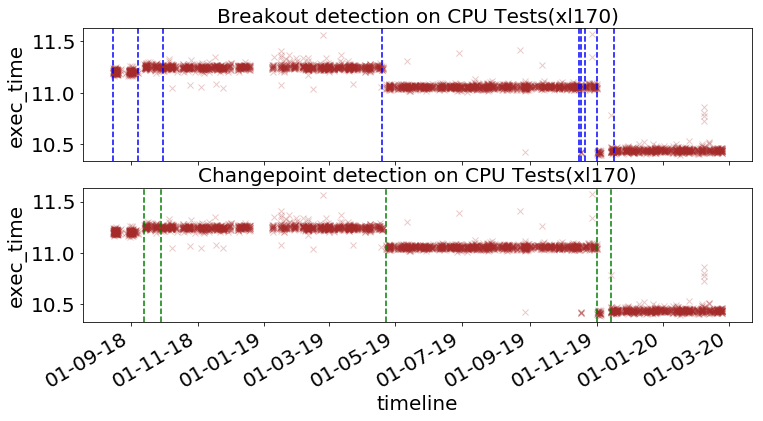

In [50]:
fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=False,figsize=(12,6))
secs = mdate.epoch2num(timestamp)

breakout = detect_breakout(exec_time,min_size=10, method='multi', degree=1, beta=0.0001)
breakout_index = [0]+breakout+[len(exec_time)]
ax1 = ax[0]
ax2 = ax[1]
ax1.plot_date(x=secs, y=exec_time, alpha=0.25, marker='x', c='brown')
ax2.plot_date(x=secs, y=exec_time, alpha=0.25, marker='x', c='brown')
mean_vals=[]
percent_change=[]

for i in range(len(breakout_index)-1):
    mean_vals.append(np.mean(exec_time[breakout_index[i]:breakout_index[i+1]]))

for v in breakout_index[:-1]:
    ax1.axvline(x=secs[v], linestyle='--', c='blue')

res=robjects.r("""
est.sd_node <- varDiff(cpu_str)
res.ou_node <- fpop_intern(cpu_str/est.sd_node,  test.stat="Outlier", pen.value=2*log(length(cpu_str)), lthreshold=2.5)
cpt_cpu_node <- res.ou_node$cpts[-length(res.ou_node$cpts)]
""")

for v in robjects.r("cpt_cpu_node"):
    ax2.axvline(x=secs[v], linestyle='--', c='green')


ax1.set_title("Breakout detection on CPU Tests(xl170)",fontsize=20)
ax2.set_title("Changepoint detection on CPU Tests(xl170)",fontsize=20)
plt.xticks(rotation=45, ha='right')
ax1.set_ylabel('exec_time',fontsize=20)
ax1.tick_params(axis='y', labelsize=20)

for ax in [ax2]:
    date_fmt = '%d-%m-%y'
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlabel('timeline',fontsize=20)
    plt.ylabel('exec_time',fontsize=20)
    date_formatter = mdate.DateFormatter(date_fmt)
    ax.xaxis.set_major_formatter(date_formatter)
    fig.autofmt_xdate()